In [1]:
import torchphysics as tp 
import torch
import pytorch_lightning as pl
# Test to learn integrator f -> u with u' = f (data driven)

T = tp.spaces.R1("t") # trunk input
U = tp.spaces.R1("u") # solution
F = tp.spaces.R1("f") # branch input
K = tp.spaces.R1("k") # parameter for function set

branch_space = tp.spaces.FunctionSpace(T, F)

domain = tp.domains.Interval(T, 0, 1)
branch_grid = tp.samplers.GridSampler(domain, 10).sample_points()

In [2]:
def custom_fn(t, k):
    return k*t

param_sampler = tp.samplers.RandomUniformSampler(
    tp.domains.Interval(K, -1, 1), 10000
)

custom_functionset = tp.domains.CustomFunctionSet(branch_space, param_sampler, custom_fn)

functionsampler = tp.samplers.FunctionSamplerRandomUniform(
        100, custom_functionset, function_creation_interval=100
    )

In [3]:
trunk_net = tp.models.FCTrunkNet(T, hidden=(10, 10))
branch_net = tp.models.FCBranchNet(branch_space, hidden=(20, 20), grid=branch_grid)
model = tp.models.DeepONet(trunk_net, branch_net, U, output_neurons=20)

In [4]:
def ode_residual(u, t, f):
    return tp.utils.grad(u, t) - f

ode_sampler = tp.samplers.RandomUniformSampler(domain, 1000)

ode_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                             branch_function_sampler=functionsampler, 
                                             trunk_points_sampler=ode_sampler, 
                                             residual_fn=ode_residual)

In [5]:
boundary_sampler = tp.samplers.RandomUniformSampler(domain.boundary_left, 10)

def initial_residual(u):
    return u

initial_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                              branch_function_sampler=functionsampler, 
                                              trunk_points_sampler=boundary_sampler, 
                                              residual_fn=initial_residual)

In [6]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0005)

solver = tp.solver.Solver([ode_cond, initial_cond], optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5000, 
                     logger=False)

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 1.4 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: User

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

torch.Size([1, 10, 1]) torch.Size([1, 1000, 1])


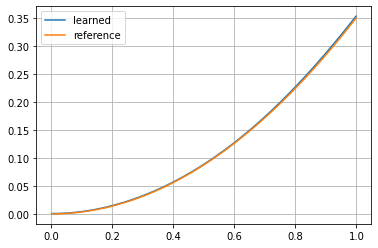

In [7]:
scale = 0.7
test_branch_input = (scale * branch_grid.as_tensor.unsqueeze(0))
test_trunk_input = tp.samplers.GridSampler(domain, 1000).sample_points().unsqueeze(0)
print(test_branch_input.shape, test_trunk_input.as_tensor.shape)
model_out = model(test_trunk_input, test_branch_input).as_tensor

import matplotlib.pyplot as plt

plt.plot(test_trunk_input.as_tensor[0], model_out.detach()[0])
plt.plot(test_trunk_input.as_tensor[0], scale/2.0*test_trunk_input.as_tensor[0]**2)
plt.legend(["learned", "reference"])
plt.grid()